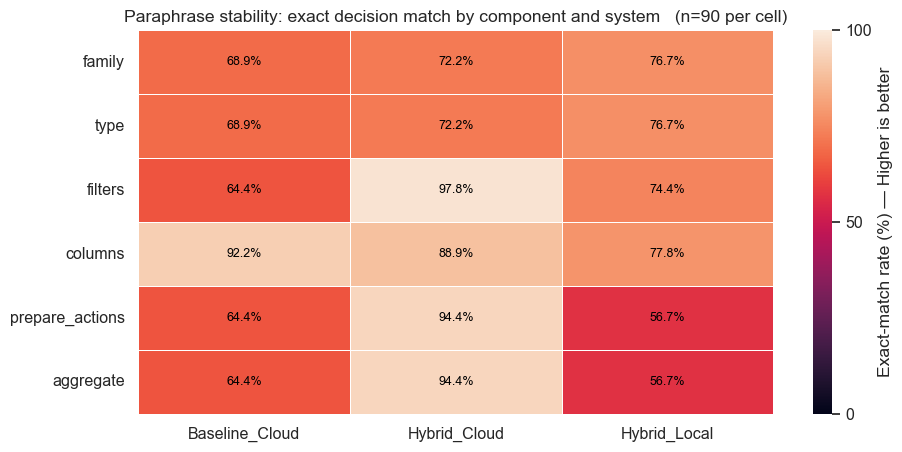

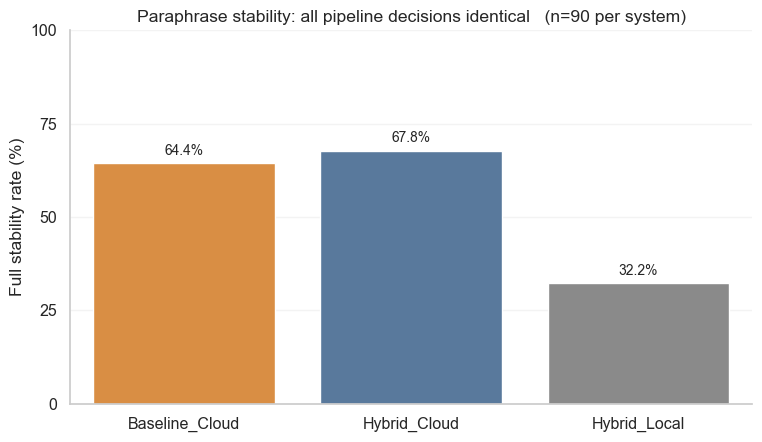

In [4]:
# ============================================================
# KERNEL 2 (simple): ONLY the first two plots
# - Plot A: Heatmap (component × system), DEFAULT style (cmap=None), % scale
#           show n ONCE in title (no per-cell n)
# - Plot B: Full stability bar plot: value labels on bars, n shown once
# - Fixes pandas/seaborn FutureWarnings
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

MIN_N = 30
systems_order = ["Baseline_Cloud", "Hybrid_Cloud", "Hybrid_Local"]
components_order = ["family", "type", "filters", "columns", "prepare_actions", "aggregate"]

palette = {
    "Baseline_Cloud": "#F28E2B",
    "Hybrid_Cloud":   "#4E79A7",
    "Hybrid_Local":   "#8A8A8A",
}

sns.set_theme(
    style="whitegrid",
    font_scale=1.05,
    rc={"axes.spines.top": False, "axes.spines.right": False, "grid.alpha": 0.22},
)

# -------------------------
# Helpers
# -------------------------
def agg_rate(df, group_cols, value_col):
    # observed=False silences pandas FutureWarning and keeps current behavior
    return df.groupby(group_cols, as_index=False, observed=False).agg(
        rate=(value_col, "mean"),
        n=(value_col, "size")
    )

def fmt_pct(x):
    return f"{x:.1f}%"

def common_n_or_none(df, col):
    ns = df.groupby("system", observed=False)[col].size()
    if len(set(ns.values)) == 1:
        return int(ns.values[0])
    return None

# Ensure system ordering
df_stability = df_stability.copy()
df_stability["system"] = pd.Categorical(df_stability["system"], categories=systems_order, ordered=True)

# ============================================================
# Plot A: Heatmap of exact-match rate by component × system
# - DEFAULT heatmap design (cmap=None)
# - percent scale (0–100)
# - n shown ONCE in title (no per-cell n)
# ============================================================
comp_long = []
for c in components_order:
    comp_long.append(
        df_stability[["system", f"match_{c}"]]
        .rename(columns={f"match_{c}": "match"})
        .assign(component=c)
    )
comp_long = pd.concat(comp_long, ignore_index=True)
comp_long["component"] = pd.Categorical(comp_long["component"], categories=components_order, ordered=True)
comp_long["system"] = pd.Categorical(comp_long["system"], categories=systems_order, ordered=True)

heat = agg_rate(comp_long, ["component", "system"], "match")
heat = heat[heat["n"] >= MIN_N].copy()
heat["rate_pct"] = heat["rate"] * 100

rate_piv = heat.pivot(index="component", columns="system", values="rate_pct").reindex(components_order)
rate_piv = rate_piv.loc[:, [s for s in systems_order if s in rate_piv.columns]]

# If n is constant across all component×system cells, show once
n_unique = sorted(heat["n"].dropna().unique().tolist())
n_title = n_unique[0] if len(n_unique) == 1 else None

fig, ax = plt.subplots(figsize=(9.6, 4.7))
sns.heatmap(
    rate_piv, ax=ax, vmin=0, vmax=100,
    cmap=None,  # <-- your preference: default styling
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Exact-match rate (%) — Higher is better", "ticks": [0, 50, 100]},
)

# annotate ONLY rate values
for i, comp in enumerate(rate_piv.index):
    for j, sys in enumerate(rate_piv.columns):
        v = rate_piv.loc[comp, sys]
        if pd.notna(v):
            ax.text(j + 0.5, i + 0.5, fmt_pct(float(v)),
                    ha="center", va="center", fontsize=9, color="black")

title = "Paraphrase stability: exact decision match by component and system"
if n_title is not None:
    title += f"   (n={int(n_title)} per cell)"
ax.set_title(title)

ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

# ============================================================
# Plot B: Full stability rate (all components match) by system
# - % scale 0..100
# - annotate exact value on top
# - show n once (if common across systems)
# - warning-free seaborn palette usage (use hue + legend=False)
# ============================================================
full = df_stability.groupby("system", as_index=False, observed=False).agg(
    rate=("match_all_components", "mean"),
    n=("match_all_components", "size"),
)
full = full[full["n"] >= MIN_N].copy()
full["rate_pct"] = full["rate"] * 100
full["system"] = pd.Categorical(full["system"], categories=systems_order, ordered=True)
full = full.sort_values("system")

n_common = common_n_or_none(df_stability, "match_all_components")

fig, ax = plt.subplots(figsize=(7.8, 4.6))
sns.barplot(
    data=full,
    x="system",
    y="rate_pct",
    hue="system",       # fixes seaborn FutureWarning
    palette=palette,
    dodge=False,
    legend=False,
    ax=ax,
    edgecolor="white",
)

ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])
ax.set_ylabel("Full stability rate (%)")
ax.set_xlabel("")

title = "Paraphrase stability: all pipeline decisions identical"
if n_common is not None:
    title += f"   (n={n_common} per system)"
ax.set_title(title)

# annotate exact % values
for i, r in full.reset_index(drop=True).iterrows():
    ax.text(i, float(r["rate_pct"]) + 1.5, fmt_pct(float(r["rate_pct"])),
            ha="center", va="bottom", fontsize=10)

# If n differs, show it once in a textbox
if n_common is None:
    n_text = "\n".join([f"{row.system}: n={int(row.n)}" for row in full.itertuples()])
    ax.text(
        0.98, 0.02, n_text,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="0.8", alpha=0.9)
    )

plt.tight_layout()
plt.show()